# Начало лабораторной работы, ух

### Выгрузим документы и ресурсы NLTK

Обработка текстов на естественном языке (Natural Language Processing, NLP) – направление развития искусственного интеллекта и компьютерной лингвистики с целью разработки методов для понимания смысла текста и генерации грамотного текста.

Популярные задачи:

• Аннотирование и реферирование текстов

• Проверка правописания

• Машинный перевод

• Понимание текста

• Генерация текста

• Вопросно-ответные системы

NLTK (Natural Language Toolkit) — пакет библиотек и программ для символьной и статистической обработки естественного языка, написанных на Python.


In [8]:
import os
import win32com.client
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Загрузка необходимых ресурсов NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Инициализация стоп-слов и лемматизатора
stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

# Загрузка модели spaCy для русского языка
nlp = spacy.load("ru_core_news_sm")

data_path = os.path.abspath(".//static//csv//tz_itdocs")

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Папка {data_path} не найдена.")

# Инициализация Word
word = win32com.client.Dispatch("Word.Application")
word.visible = False

texts = []
for filename in os.listdir(data_path):
    if filename.endswith(".doc"):
        file_path = os.path.join(data_path, filename)
        try:
            doc = word.Documents.Open(file_path)
            text = doc.Content.Text
            texts.append(text)
            doc.Close(SaveChanges=False)
        except Exception as e:
            print(f"Ошибка при чтении файла {filename}: {e}")
word.Quit()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Применим методы предобработки текста

Предобработка текста является важным этапом, на котором решаются следующие задачи:
1. Трансформация
2. Токенизация
3. Выделение частей речи (POS tagging)
4. Нормализация
5. Фильтрация

Наш процесс предобработки будет выгялдеть следующим образом:
* Удаление спецсимволов(удаление из текста всех символов, которые не являются буквами или цифрами (например, знаки препинания, символы @, #, $, и т.д.))
* Приведение к нижнему регистру 
* Токенизация(разделение текста на отдельные слова или токены (например, предложение разбивается на список слов))
* Удаление стоп-слов(удаление из текста слов, которые не несут смысловой нагрузки (например, предлоги, союзы, местоимения))
* Фильтрация по длине токенов(удаление из текста слов, которые слишком короткие (например, меньше 2 символов) или слишком длинные)
* Лемматизация по длине токенов(приведение слов к их начальной форме (лемме). Например, "бежал" → "бежать", "кошки" → "кошка")
* Удаление лишних пробелов


In [9]:
def preprocess_text(text):
    # Удаление спецсимволов
    text = re.sub(r'\W+', ' ', text)  # Удаляем все, кроме букв, цифр и пробелов
    # Приведение к нижнему регистру
    text = text.lower()
    # Токенизация
    tokens = text.split()
    # Удаление стоп-слов, лемматизация и фильтрация по длине токенов
    tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word not in stop_words and len(word) > 2
    ]
    # Удаление лишних пробелов
    tokens = ' '.join(tokens).strip()
    return tokens

# Применение предобработки к каждому документу
texts = [preprocess_text(text) for text in texts]

### Обработуем документы на основе лемматизации

In [10]:
def lemmatize_text(texts):
    lemmatized_texts = []
    for doc in nlp.pipe(texts):
        lemmatized_texts.append(" ".join([token.lemma_ for token in doc]))
    return lemmatized_texts

# Лемматизация текстов
lemmatized_texts = lemmatize_text(texts)

### Удалим редкие и частые слова на основе лематизации

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=3, max_features=10000)
X_filtered = vectorizer.fit_transform(lemmatized_texts)

### Формируем N-граммы

Формирование N-грамм — это процесс разбиения текста на последовательности из N слов или символов. N-граммы широко используются в обработке NLP для анализа текста, построения языковых моделей, классификации текста и других задач.

N-грамма — это последовательность из N элементов (слов, символов или других единиц).

N — это число, которое определяет длину последовательности:

* Униграммы (1-граммы): Отдельные слова или символы

* Биграммы (2-граммы): Пары последовательных слов или символов

* Триграммы (3-граммы): Тройки последовательных слов или символов

И так далее.

Зачем нужны N-граммы?
* Анализ контекста:

  N-граммы позволяют учитывать контекст слов. Например, биграммы помогают понять, как слова связаны друг с другом

* Построение языковых моделей:

  N-граммы используются для создания моделей, которые предсказывают следующее слово в последовательности (например, в автодополнении)

* Классификация текста:

  N-граммы могут использоваться как признаки для классификации текста (например, определение тематики или тональности)

* Поиск шаблонов:

  N-граммы помогают находить часто встречающиеся последовательности слов или символов

TF-IDF векторизация — это метод преобразования текстовых данных в числовые векторы, который учитывает важность слов в документе относительно всей коллекции документов (корпуса).

* TF-IDF расшифровывается как Term Frequency-Inverse Document Frequency (Частота термина – Обратная частота документа). Он состоит из двух компонентов:
* TF (Term Frequency):

  * Частота термина в документе.

  * Показывает, насколько часто слово встречается в конкретном документе.

  Формула:

  TF(t,d) = Количество вхождений термина t в документ d  / Общее количество терминов в документе d
​
* IDF (Inverse Document Frequency):

  * Обратная частота документа.

  * Показывает, насколько редким является слово во всей коллекции документов.

  Формула:
  
  IDF(t,D) = log(Общее количество документов в корпусе D / Количество документов, содержащих термин t)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Формирование N-грамм (одиночные слова до триады) с использованием TF-IDF векторизации
vectorizer_ngrams = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)

# Подготовка N-грамм из лемматизированных текстов
X_ngrams = vectorizer_ngrams.fit_transform(lemmatized_texts)

print(f"Количество признаков (N-грамм): {X_ngrams.shape[1]}")
print(f"Размерность данных N-грамм: {X_ngrams.shape}")

Количество признаков (N-грамм): 10000
Размерность данных N-грамм: (41, 10000)


### Индексируем текст TF-IDF

In [35]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(lemmatized_texts)

### Выполним обучение модели с учителем или без учителя для решения задач. Оценим качество решений

#### Обучаем модель и оцениеваем её качество с помощью кластеризации

Силуэт-коэффициент: 0.09539462151298214


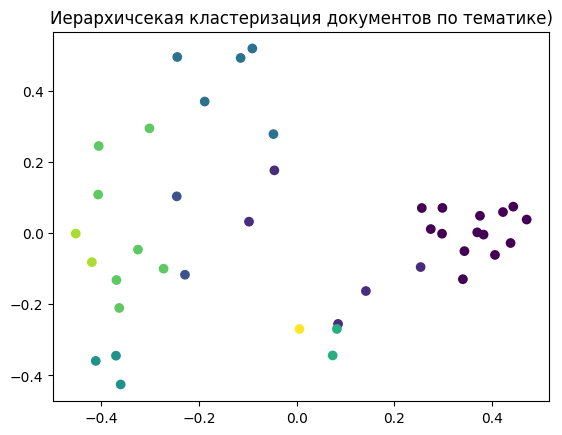

In [38]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Кластеризация с использованием иерархической кластеризации
n_clusters = 9  
hierarchical_clustering = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical_clustering.fit(X_tfidf.toarray())  # Преобразуем X_tfidf в массив, если это необходимо

# Получение меток кластеров
cluster_labels = hierarchical_clustering.labels_

# Оценка качества кластеризации
silhouette_avg = silhouette_score(X_tfidf.toarray(), cluster_labels)  # Преобразуем X_tfidf в массив
print(f"Силуэт-коэффициент: {silhouette_avg}")

# Визуализация кластеров
pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title("Иерархичсекая кластеризация документов по тематике)")
plt.show()


Значение силуэт коэффициента: от -1 до 0.25	

Интерпретация: плохая кластеризация. Кластеры плохо разделены или объекты ошибочно отнесены.

#### Обучаем модель и оцениеваем её качество с помощью классификации

Разделим документы на 2 типа: техническое задание (ТЗ) и научную статью

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

# Определяем метки для классификации: 0 - Техническое задание (ТЗ), 1 - статья
# Исходя из примера, создаем метки для 41 текста: 20 "ТЗ" и 21 "статья"
labels = [0, 1] * 20 + [0]

# Разделение данных на обучающую и тестовую выборки (80% на обучение, 20% на тестирование)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=51)

# Инициализируем модель логистической регрессии с максимальным количеством итераций для достижения сходимости
model = LogisticRegression(max_iter=1000)

# Обучаем модель на обучающей выборке
model.fit(X_train, y_train)

# Выполняем предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Оценка производительности модели
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # Используем взвешенное среднее для F1-меры

# Выводим результаты оценки
print(f"Точность модели: {accuracy:.2f}")
print(f"F1-мера: {f1:.2f}")

Точность модели: 0.56
F1-мера: 0.56


Точность — доля правильно классифицированных объектов от общего числа объектов. Точность 0.56 означает, что модель правильно классифицировала 56% всех объектов. Это довольно низкий показатель, так как идеальная точность равна 1.0 (100% правильных предсказаний).

F1-мера — это гармоническое среднее между точностью (Precision) и полнотой (Recall). Она учитывает как ложноположительные, так и ложноотрицательные ошибки.

* Precision (Точность) — доля правильно предсказанных положительных классов среди всех предсказанных положительных классов.

* Recall (Полнота) — доля правильно предсказанных положительных классов среди всех реальных положительных классов.

F1-мера 0.56 указывает на то, что модель имеет среднее качество классификации. Это значение говорит о том, что модель плохо балансирует между точностью и полнотой. Например, она может либо пропускать много положительных примеров (низкий Recall), либо делать много ложноположительных предсказаний (низкий Precision).

Точности указывают на то, что модель работает не очень хорошо. Это может быть связано с качеством данных, слабостью модели или дисбалансом классов. Для улучшения результатов необходимо проанализировать данные, попробовать более сложные модели и настроить гиперпараметры.